---
Bike sharing challenge

George Tzannetos

25/02/2020

---

In this report, we go through the analysis and modeling of the San Francisco bike share data. The goal is to provide a model that predicts the net change of bikes in each station for the next hour. 

# Data Exploration

The first part is to import the data and explore them. That means understand the data, clean then, find missing values, and understand which one could be important for our case.

In [43]:
import pandas as pd 
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [45]:
# I ignore the warning so that the report is easier to read
import warnings
warnings.filterwarnings("ignore")

In [3]:
trips = pd.read_csv("../data/trip_data.csv",parse_dates=[1,3],dayfirst=True)
weather = pd.read_csv("../data/weather_data.csv",parse_dates=[0],dayfirst=True)
stations = pd.read_csv("../data/station_data.csv")

In [4]:
trips.head(5)

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer


In [5]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 6 columns):
Trip ID            354152 non-null int64
Start Date         354152 non-null datetime64[ns]
Start Station      354152 non-null int64
End Date           354152 non-null datetime64[ns]
End Station        354152 non-null int64
Subscriber Type    354152 non-null object
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 16.2+ MB


Explore if missing values are contained in the trips dataframe

In [6]:
trips.isnull().sum()

Trip ID            0
Start Date         0
Start Station      0
End Date           0
End Station        0
Subscriber Type    0
dtype: int64

No missing values are contained. Moreover thinking about our end goal the idea would be to collect from the trips dataframe how many trips started and ended in each station for each hour.

In [7]:
weather.head(5)

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [8]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 24 columns):
Date                         1825 non-null datetime64[ns]
Max TemperatureF             1821 non-null float64
Mean TemperatureF            1821 non-null float64
Min TemperatureF             1821 non-null float64
Max Dew PointF               1775 non-null float64
MeanDew PointF               1775 non-null float64
Min DewpointF                1775 non-null float64
Max Humidity                 1775 non-null float64
Mean Humidity                1775 non-null float64
Min Humidity                 1775 non-null float64
Max Sea Level PressureIn     1824 non-null float64
Mean Sea Level PressureIn    1824 non-null float64
Min Sea Level PressureIn     1824 non-null float64
Max VisibilityMiles          1820 non-null float64
Mean VisibilityMiles         1820 non-null float64
Min VisibilityMiles          1820 non-null float64
Max Wind SpeedMPH            1824 non-null float64
Mean Wind SpeedMPH 

We can see that the weather dataframe contains a lot of weather information. One important remark is that the weather info are daily and not hourly,as we want our predictive model to be.

In [9]:
weather.Zip.unique()

array([94107, 94063, 94301, 94041, 95113])

We have 365 uniques dates in our date range and the weather data contain 1825 entries. That means that we have weather data for each one of the zip locations every day.

In [10]:
weather.isnull().sum()

Date                            0
Max TemperatureF                4
Mean TemperatureF               4
Min TemperatureF                4
Max Dew PointF                 50
MeanDew PointF                 50
Min DewpointF                  50
Max Humidity                   50
Mean Humidity                  50
Min Humidity                   50
Max Sea Level PressureIn        1
Mean Sea Level PressureIn       1
Min Sea Level PressureIn        1
Max VisibilityMiles             5
Mean VisibilityMiles            5
Min VisibilityMiles             5
Max Wind SpeedMPH               1
Mean Wind SpeedMPH              1
Max Gust SpeedMPH             541
PrecipitationIn                 1
CloudCover                      1
Events                       1538
WindDirDegrees                  1
Zip                             0
dtype: int64

In [11]:
weather.Events.unique()

array([nan, 'Rain', 'Fog', 'Fog-Rain', 'Rain-Thunderstorm'], dtype=object)

We can see that Events column contains multiple nan values, but it can be safely assumed that no event happened in that day, thus it was a day with a normal weather. 

In [12]:
# The empty events data are changed to Normal and then we convert the categorical values to indicator values
weather.loc[weather.Events.isnull(), 'Events'] = "Normal"
#events = pd.get_dummies(weather["Events"])

In [13]:
weather

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,Normal,290.0,94107
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,Normal,290.0,94107
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,Normal,276.0,94107
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,Normal,301.0,94107
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,Normal,309.0,94107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2015-08-27,92.0,78.0,63.0,57.0,51.0,40.0,78.0,48.0,18.0,...,10.0,10.0,23.0,6.0,29.0,0.0,3.0,Normal,313.0,95113
1821,2015-08-28,95.0,80.0,64.0,64.0,56.0,52.0,93.0,60.0,26.0,...,10.0,10.0,25.0,7.0,30.0,0.0,3.0,Normal,307.0,95113
1822,2015-08-29,80.0,72.0,64.0,65.0,62.0,54.0,93.0,70.0,47.0,...,10.0,10.0,21.0,9.0,26.0,0.0,4.0,Normal,312.0,95113
1823,2015-08-30,78.0,70.0,62.0,60.0,57.0,53.0,84.0,64.0,43.0,...,10.0,10.0,22.0,10.0,29.0,0.0,3.0,Normal,291.0,95113


Since the missing values are float we can fill them with the mean values of each respective column

In [14]:
weather.fillna(weather.mean(), inplace=True)

In [15]:
## We can check now the missing values again
weather.isnull().sum()

Date                         0
Max TemperatureF             0
Mean TemperatureF            0
Min TemperatureF             0
Max Dew PointF               0
MeanDew PointF               0
Min DewpointF                0
Max Humidity                 0
Mean Humidity                0
Min Humidity                 0
Max Sea Level PressureIn     0
Mean Sea Level PressureIn    0
Min Sea Level PressureIn     0
Max VisibilityMiles          0
Mean VisibilityMiles         0
Min VisibilityMiles          0
Max Wind SpeedMPH            0
Mean Wind SpeedMPH           0
Max Gust SpeedMPH            0
PrecipitationIn              0
CloudCover                   0
Events                       0
WindDirDegrees               0
Zip                          0
dtype: int64

Now we move the the stations exploration.

In [16]:
stations.head(5)

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [17]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
Id            76 non-null int64
Name          76 non-null object
Lat           76 non-null float64
Long          76 non-null float64
Dock Count    76 non-null int64
City          76 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 3.7+ KB


In [18]:
stations.isnull().sum()

Id            0
Name          0
Lat           0
Long          0
Dock Count    0
City          0
dtype: int64

Some of the stations are moved and changed, however there is the information missing about the installation time of each station, thus we consider each station independant.

We can proceed now with starting to combining the dataframes and generating the train data.

The idea is to create a dataframe for the date range 01/09/2014 until 31/08/2015 with one row for each hour of the day. We should do the same for each station ID. 

In [46]:
dates = pd.date_range(start="9/1/2014",end="9/1/2015",freq="H")
weekdays = dates.weekday
only_date = dates.date

#Find business days and holidays
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=dates.date.min(), end=dates.date.max())

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=dates.date.min(), end=dates.date.max(), freq=us_bd)

business_days = pd.to_datetime(business_days, format='%d/%m/%Y').date
holidays = pd.to_datetime(holidays, format='%d/%m/%Y').date


date_df = pd.DataFrame(dates,columns=["Time"])
date_df["Weekday"] = weekdays
date_df["Date"] = only_date

# Add the business and holidays 

date_df['Business_day'] = date_df['Date'].isin(business_days)
date_df['Holiday'] = date_df['Date'].isin(holidays)

date_df.Business_day = date_df.Business_day.map(lambda x: 1 if x == True else 0)
date_df.Holiday = date_df.Holiday.map(lambda x: 1 if x == True else 0)

# Change format 
dates = pd.to_datetime(dates).strftime('%d/%m/%Y %H')
only_date = pd.to_datetime(only_date)#.strftime('%d/%m/%Y')
# Replace with correct format
date_df["Date"] = only_date
date_df["Time"] = dates

In [20]:
date_df

,Time,Weekday,Date,Business_day,Holiday
0,01/09/2014 00,0,2014-09-01,0,1
1,01/09/2014 01,0,2014-09-01,0,1
2,01/09/2014 02,0,2014-09-01,0,1
3,01/09/2014 03,0,2014-09-01,0,1
4,01/09/2014 04,0,2014-09-01,0,1
...,...,...,...,...,...
8756,31/08/2015 20,0,2015-08-31,1,0
8757,31/08/2015 21,0,2015-08-31,1,0
8758,31/08/2015 22,0,2015-08-31,1,0
8759,31/08/2015 23,0,2015-08-31,1,0


We create a date dataframe containing each day and hour from 01/09/2014 00 till 01/09/2015 00. The weekdays column is also added, showing 0-->Monday and 6--> Sunday. Also Business day is added and Holiday columns as features.

Next part would be to match the location the stations with the zip location of the weather data. The matching is the following:
 {94107: 'San Francisco', 94063: 'Redwood City', 94301: 'Palo Alto', 94041: 'Mountain View', 95113: 'San Jose'}

In [21]:
stations["Zip"] = np.nan
stations.loc[stations['City'] == 'San Jose','Zip'] = 95113
stations.loc[stations['City'] == 'Redwood City','Zip'] = 94063
stations.loc[stations['City'] == 'San Francisco','Zip'] = 94107
stations.loc[stations['City'] == 'Palo Alto','Zip'] = 94301
stations.loc[stations['City'] == 'Mountain View','Zip'] = 94041 

In [22]:
stations

,Id,Name,Lat,Long,Dock Count,City,Zip
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,95113.0
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,95113.0
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,95113.0
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,95113.0
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,95113.0
...,...,...,...,...,...,...,...
71,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,94107.0
72,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,95113.0
73,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,94107.0
74,83,Mezes Park,37.491269,-122.236234,15,Redwood City,94063.0


In [23]:
# Here all the dates for each one of the stations is concatenated to create the complete 1year24hour representation for 
# each one of the stations

dates_df = pd.concat([date_df]*len(stations.index), ignore_index=True)
## List of indices and list of stations
loi = np.arange(0,674597,8761)

station_ids = []
dock_count = []
zip_loc = []
for _,row in stations.iterrows():
    
    station_ids.append(row["Id"])
    dock_count.append(row["Dock Count"])
    zip_loc.append(row["Zip"])

for i in range(len(loi)-1):
    dates_df.loc[loi[i]:loi[i+1]-1, "Station_ID"] = station_ids[i]
    dates_df.loc[loi[i]:loi[i+1]-1, "Dock_count"] = dock_count[i]
    dates_df.loc[loi[i]:loi[i+1]-1, "Zip"] = zip_loc[i]

In [24]:
dates_df

,Time,Weekday,Date,Business_day,Holiday,Station_ID,Dock_count,Zip
0,01/09/2014 00,0,2014-09-01,0,1,2.0,27.0,95113.0
1,01/09/2014 01,0,2014-09-01,0,1,2.0,27.0,95113.0
2,01/09/2014 02,0,2014-09-01,0,1,2.0,27.0,95113.0
3,01/09/2014 03,0,2014-09-01,0,1,2.0,27.0,95113.0
4,01/09/2014 04,0,2014-09-01,0,1,2.0,27.0,95113.0
...,...,...,...,...,...,...,...,...
665831,31/08/2015 20,0,2015-08-31,1,0,84.0,15.0,95113.0
665832,31/08/2015 21,0,2015-08-31,1,0,84.0,15.0,95113.0
665833,31/08/2015 22,0,2015-08-31,1,0,84.0,15.0,95113.0
665834,31/08/2015 23,0,2015-08-31,1,0,84.0,15.0,95113.0


Next part which is important for our case is to count how many trips started and ended for each station every hour, e.g give me the trips started at station 2 at 01/09/2014 from 1:00 till 1:59. Then it would be possible to find the net change at this specific station for the following hour by subtracting (trips ended - trips started)

In [25]:
# I take the starting datetime and split it to date and time
trips_dates = pd.to_datetime(trips["Start Date"])
#start_dates = trips_dates.apply(lambda x: x.strftime('%d/%m/%Y %H'))
trips["New_dates"] = pd.to_datetime(trips_dates).dt.date
trips["Hours"] = pd.to_datetime(trips_dates).dt.hour

# I groupby the trips together with the dates and hours and count how many trips started at each station

start = trips["Start Station"].groupby([trips['New_dates'],trips['Hours']]).value_counts().to_frame()
start['Date'] = start.index.get_level_values('New_dates')
start['Hours'] = start.index.get_level_values('Hours') 
start['Station_ID'] = start.index.get_level_values('Start Station') 
start.columns = ['Start_CountTrips', 'Date','Hours','Station_ID']
start.reset_index(drop=True,inplace=True)
start["Date"] = pd.to_datetime(start.Date)

In [26]:
start

,Start_CountTrips,Date,Hours,Station_ID
0,3,2014-09-01,0,66
1,1,2014-09-01,3,50
2,1,2014-09-01,4,39
3,1,2014-09-01,4,66
4,1,2014-09-01,5,68
...,...,...,...,...
142510,1,2015-08-31,23,10
142511,1,2015-08-31,23,31
142512,1,2015-08-31,23,47
142513,1,2015-08-31,23,50


In [27]:
start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142515 entries, 0 to 142514
Data columns (total 4 columns):
Start_CountTrips    142515 non-null int64
Date                142515 non-null datetime64[ns]
Hours               142515 non-null int64
Station_ID          142515 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.3 MB


In [28]:
dates_df["Hours"] = pd.to_datetime(dates_df.Time).dt.hour
dates_df["Date"] = pd.to_datetime(dates_df.Date)
dates_df

,Time,Weekday,Date,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours
0,01/09/2014 00,0,2014-09-01,0,1,2.0,27.0,95113.0,0
1,01/09/2014 01,0,2014-09-01,0,1,2.0,27.0,95113.0,1
2,01/09/2014 02,0,2014-09-01,0,1,2.0,27.0,95113.0,2
3,01/09/2014 03,0,2014-09-01,0,1,2.0,27.0,95113.0,3
4,01/09/2014 04,0,2014-09-01,0,1,2.0,27.0,95113.0,4
...,...,...,...,...,...,...,...,...,...
665831,31/08/2015 20,0,2015-08-31,1,0,84.0,15.0,95113.0,20
665832,31/08/2015 21,0,2015-08-31,1,0,84.0,15.0,95113.0,21
665833,31/08/2015 22,0,2015-08-31,1,0,84.0,15.0,95113.0,22
665834,31/08/2015 23,0,2015-08-31,1,0,84.0,15.0,95113.0,23


At this part I will merge the two dataframes, i.e dates_df with the start df I created. The merge will happen using the columns Date,Time and StationID and is outer merge

In [29]:
merged_start = pd.merge(dates_df,start,on=["Date","Hours","Station_ID"],how="outer")
merged_start['Start_CountTrips'].fillna(0,inplace=True)

In [30]:
merged_start

,Time,Weekday,Date,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours,Start_CountTrips
0,01/09/2014 00,0,2014-09-01,0,1,2.0,27.0,95113.0,0,0.0
1,01/09/2014 01,0,2014-09-01,0,1,2.0,27.0,95113.0,1,0.0
2,01/09/2014 02,0,2014-09-01,0,1,2.0,27.0,95113.0,2,0.0
3,01/09/2014 03,0,2014-09-01,0,1,2.0,27.0,95113.0,3,0.0
4,01/09/2014 04,0,2014-09-01,0,1,2.0,27.0,95113.0,4,0.0
...,...,...,...,...,...,...,...,...,...,...
665831,31/08/2015 20,0,2015-08-31,1,0,84.0,15.0,95113.0,20,0.0
665832,31/08/2015 21,0,2015-08-31,1,0,84.0,15.0,95113.0,21,0.0
665833,31/08/2015 22,0,2015-08-31,1,0,84.0,15.0,95113.0,22,0.0
665834,31/08/2015 23,0,2015-08-31,1,0,84.0,15.0,95113.0,23,0.0


The hourly trip counts are merged with the total dates dataframe. The same procedure follows for the stop trips. 

In [31]:
trips_cp = trips.copy()

# I take the starting datetime and split it to date and time
stop_trips_dates = pd.to_datetime(trips["End Date"])
trips_cp["New_dates"] = pd.to_datetime(stop_trips_dates).dt.date
trips_cp["Hours"] = pd.to_datetime(stop_trips_dates).dt.hour

# I groupby the trips together with the dates and hours and count how many trips started at each station

stop = trips_cp["End Station"].groupby([trips_cp['New_dates'],trips_cp['Hours']]).value_counts().to_frame()
stop['Date'] = stop.index.get_level_values('New_dates')
stop['Hours'] = stop.index.get_level_values('Hours') 
stop['Station_ID'] = stop.index.get_level_values('End Station') 
stop.columns = ['Stop_CountTrips', 'Date','Hours','Station_ID']
stop.reset_index(drop=True,inplace=True)
stop["Date"] = pd.to_datetime(stop.Date)

In [32]:
stop

,Stop_CountTrips,Date,Hours,Station_ID
0,3,2014-09-01,0,57
1,1,2014-09-01,4,65
2,1,2014-09-01,5,70
3,1,2014-09-01,5,72
4,1,2014-09-01,6,74
...,...,...,...,...
138660,2,2015-08-31,23,60
138661,2,2015-08-31,23,70
138662,1,2015-08-31,23,8
138663,1,2015-08-31,23,27


In [33]:
# I can now merge the start trips at stations with the stop trips at stations 

start_stop_merged = pd.merge(merged_start,stop,on=["Date","Hours","Station_ID"],how="outer")
start_stop_merged['Stop_CountTrips'].fillna(0,inplace=True)
start_stop_merged

,Time,Weekday,Date,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours,Start_CountTrips,Stop_CountTrips
0,01/09/2014 00,0,2014-09-01,0,1,2.0,27.0,95113.0,0,0.0,0.0
1,01/09/2014 01,0,2014-09-01,0,1,2.0,27.0,95113.0,1,0.0,0.0
2,01/09/2014 02,0,2014-09-01,0,1,2.0,27.0,95113.0,2,0.0,0.0
3,01/09/2014 03,0,2014-09-01,0,1,2.0,27.0,95113.0,3,0.0,0.0
4,01/09/2014 04,0,2014-09-01,0,1,2.0,27.0,95113.0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
665831,31/08/2015 20,0,2015-08-31,1,0,84.0,15.0,95113.0,20,0.0,0.0
665832,31/08/2015 21,0,2015-08-31,1,0,84.0,15.0,95113.0,21,0.0,0.0
665833,31/08/2015 22,0,2015-08-31,1,0,84.0,15.0,95113.0,22,0.0,0.0
665834,31/08/2015 23,0,2015-08-31,1,0,84.0,15.0,95113.0,23,0.0,0.0


Our target variable should be in each column the difference between Stop_CountTrips and Start_CountTrips.

In [34]:
start_stop_merged["Net_Rate"] = start_stop_merged["Stop_CountTrips"]-start_stop_merged["Start_CountTrips"]

Another addition to the training data would be to add the weather conditions for each station each day(since we are missing hourly data). This is done by merging the weather data with the merged dataframe that was created.

In [35]:
merged_weather = pd.merge(start_stop_merged,weather,on=["Date","Zip"],how="outer")

In [36]:
# The data with date 01/09/2015 are removed since there is no weather and trip data at this date.

# Drop the data samples with dates 1/9/2015 and then date column 
merged_weather.drop(merged_weather[merged_weather['Date'] == '2015-09-01'].index, inplace=True)
#merged_weather.drop(columns=['Date'],inplace=True)

In [37]:
dataset = merged_weather
dataset

,Time,Weekday,Date,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours,Start_CountTrips,...,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees
0,01/09/2014 00,0,2014-09-01,0,1,2.0,27.0,95113.0,0,0.0,...,10.0,10.0,10.0,17.0,5.0,22.0,0.0,0.0,Normal,296.0
1,01/09/2014 01,0,2014-09-01,0,1,2.0,27.0,95113.0,1,0.0,...,10.0,10.0,10.0,17.0,5.0,22.0,0.0,0.0,Normal,296.0
2,01/09/2014 02,0,2014-09-01,0,1,2.0,27.0,95113.0,2,0.0,...,10.0,10.0,10.0,17.0,5.0,22.0,0.0,0.0,Normal,296.0
3,01/09/2014 03,0,2014-09-01,0,1,2.0,27.0,95113.0,3,0.0,...,10.0,10.0,10.0,17.0,5.0,22.0,0.0,0.0,Normal,296.0
4,01/09/2014 04,0,2014-09-01,0,1,2.0,27.0,95113.0,4,0.0,...,10.0,10.0,10.0,17.0,5.0,22.0,0.0,0.0,Normal,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665792,31/08/2015 19,0,2015-08-31,1,0,82.0,15.0,94107.0,19,1.0,...,10.0,10.0,9.0,18.0,9.0,21.0,0.0,1.0,Normal,246.0
665793,31/08/2015 20,0,2015-08-31,1,0,82.0,15.0,94107.0,20,0.0,...,10.0,10.0,9.0,18.0,9.0,21.0,0.0,1.0,Normal,246.0
665794,31/08/2015 21,0,2015-08-31,1,0,82.0,15.0,94107.0,21,0.0,...,10.0,10.0,9.0,18.0,9.0,21.0,0.0,1.0,Normal,246.0
665795,31/08/2015 22,0,2015-08-31,1,0,82.0,15.0,94107.0,22,0.0,...,10.0,10.0,9.0,18.0,9.0,21.0,0.0,1.0,Normal,246.0


In [38]:
dataset.describe()

,Weekday,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours,Start_CountTrips,Stop_CountTrips,Net_Rate,...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
count,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,...,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000,665760.000000
mean,2.991781,0.687671,0.027397,46.513158,17.815789,94320.263158,11.500000,0.531951,0.531951,0.000000,...,29.960170,10.144408,9.509226,7.747467,16.935138,6.710553,22.112810,0.033161,3.576408,256.431756
std,2.003406,0.463443,0.163238,25.969887,3.989168,413.141403,6.922192,1.629249,1.730788,1.592348,...,0.131206,1.227468,1.255915,3.024935,6.880511,3.350704,5.982081,0.201655,2.305355,82.000923
min,0.000000,0.000000,0.000000,2.000000,11.000000,94041.000000,0.000000,0.000000,0.000000,-37.000000,...,29.340000,5.000000,4.000000,0.000000,4.000000,0.000000,7.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,25.750000,15.000000,94107.000000,5.750000,0.000000,0.000000,0.000000,...,29.860000,10.000000,9.000000,6.000000,13.000000,4.000000,20.000000,0.000000,2.000000,244.000000
50%,3.000000,1.000000,0.000000,47.500000,15.000000,94107.000000,11.500000,0.000000,0.000000,0.000000,...,29.950000,10.000000,10.000000,10.000000,17.000000,6.000000,21.690810,0.000000,4.000000,281.000000
75%,5.000000,1.000000,0.000000,68.250000,19.000000,94301.000000,17.250000,0.000000,0.000000,0.000000,...,30.050000,10.000000,10.000000,10.000000,20.000000,9.000000,24.000000,0.000000,5.000000,307.000000
max,6.000000,1.000000,1.000000,90.000000,27.000000,95113.000000,23.000000,52.000000,56.000000,50.000000,...,30.360000,20.000000,20.000000,20.000000,128.000000,23.000000,62.000000,3.360000,8.000000,360.000000


In [39]:
correlation = dataset.corr()
correlation

,Weekday,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours,Start_CountTrips,Stop_CountTrips,Net_Rate,...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
Weekday,1.000000e+00,-7.227637e-01,-1.333523e-01,7.405186e-16,2.837516e-15,-2.449051e-15,-1.921132e-17,-0.108924,-0.102531,2.825057e-06,...,-2.946843e-02,1.494231e-02,-4.543548e-04,9.304483e-03,-2.783175e-02,-4.373204e-02,-3.274058e-02,-4.950631e-03,2.707276e-02,-1.807789e-02
Business_day,-7.227637e-01,1.000000e+00,-2.490407e-01,5.916985e-16,8.975182e-15,-6.617513e-15,4.782342e-21,0.134729,0.126750,-8.141571e-05,...,-1.641854e-02,-1.325865e-02,-1.822459e-02,-3.254694e-02,3.001860e-02,3.729389e-02,1.816629e-02,4.663640e-02,-2.333388e-02,2.225218e-03
Holiday,-1.333523e-01,-2.490407e-01,1.000000e+00,3.719302e-15,-2.136653e-14,2.957843e-14,4.722565e-21,-0.025255,-0.023779,-5.778609e-06,...,1.062251e-02,-1.146948e-02,-4.749646e-03,6.784081e-03,-2.663027e-02,-1.423743e-02,-1.617639e-03,-2.734886e-02,-5.623731e-02,2.016563e-02
Station_ID,7.405186e-16,5.916985e-16,3.719302e-15,1.000000e+00,2.710607e-01,-5.696462e-01,-8.320204e-18,0.166483,0.156236,-5.209000e-04,...,4.781608e-03,-5.650236e-02,-5.395323e-02,-7.957851e-02,7.564176e-02,1.911419e-01,1.087102e-01,1.244041e-02,1.523160e-01,-2.252190e-02
Dock_count,2.837516e-15,8.975182e-15,-2.136653e-14,2.710607e-01,1.000000e+00,-1.814409e-01,1.159494e-21,0.147596,0.143443,4.897616e-03,...,-2.880571e-03,-9.410032e-02,-4.640723e-02,-4.162253e-02,5.524657e-02,1.142939e-01,4.791440e-02,1.913469e-02,9.639319e-02,-2.292182e-02
Zip,-2.449051e-15,-6.617513e-15,2.957843e-14,-5.696462e-01,-1.814409e-01,1.000000e+00,0.000000e+00,-0.128571,-0.121009,2.084573e-05,...,-2.689629e-02,-2.803920e-03,2.701259e-02,6.611461e-02,-2.472153e-02,-9.843400e-02,-1.009448e-01,4.085402e-03,-4.054533e-02,2.572599e-03
Hours,-1.921132e-17,4.782342e-21,4.722565e-21,-8.320204e-18,1.159494e-21,0.000000e+00,1.000000e+00,0.070981,0.075777,9.738696e-03,...,-2.350206e-20,1.130477e-20,-9.698317e-20,-3.930924e-18,3.821511e-18,-1.061505e-17,6.684674e-18,-2.934658e-19,-6.687929e-22,1.293222e-18
Start_CountTrips,-1.089239e-01,1.347285e-01,-2.525548e-02,1.664825e-01,1.475961e-01,-1.285710e-01,7.098116e-02,1.000000,0.552240,-4.229215e-01,...,-5.993354e-03,-3.751730e-02,-1.106571e-02,-1.505725e-02,3.748253e-02,8.705327e-02,2.369109e-02,-1.764292e-02,4.999682e-02,9.333367e-03
Stop_CountTrips,-1.025311e-01,1.267496e-01,-2.377915e-02,1.562364e-01,1.434431e-01,-1.210091e-01,7.577669e-02,0.552240,1.000000,5.219029e-01,...,-5.569187e-03,-3.520247e-02,-1.041653e-02,-1.418825e-02,3.524472e-02,8.198787e-02,2.234935e-02,-1.669389e-02,4.707085e-02,8.750783e-03
Net_Rate,2.825057e-06,-8.141571e-05,-5.778609e-06,-5.209000e-04,4.897616e-03,2.084573e-05,9.738696e-03,-0.422922,0.521903,1.000000e+00,...,7.886749e-05,1.237259e-04,1.706418e-18,-1.559190e-05,-4.222552e-05,4.532468e-05,5.231129e-05,-9.349868e-05,7.774289e-06,-3.807625e-05


Here it can be seen how our features are corellated. For example we can see that business day and weekdays are highly corellated. Also zip with stationID and the temperatures with the dew points.

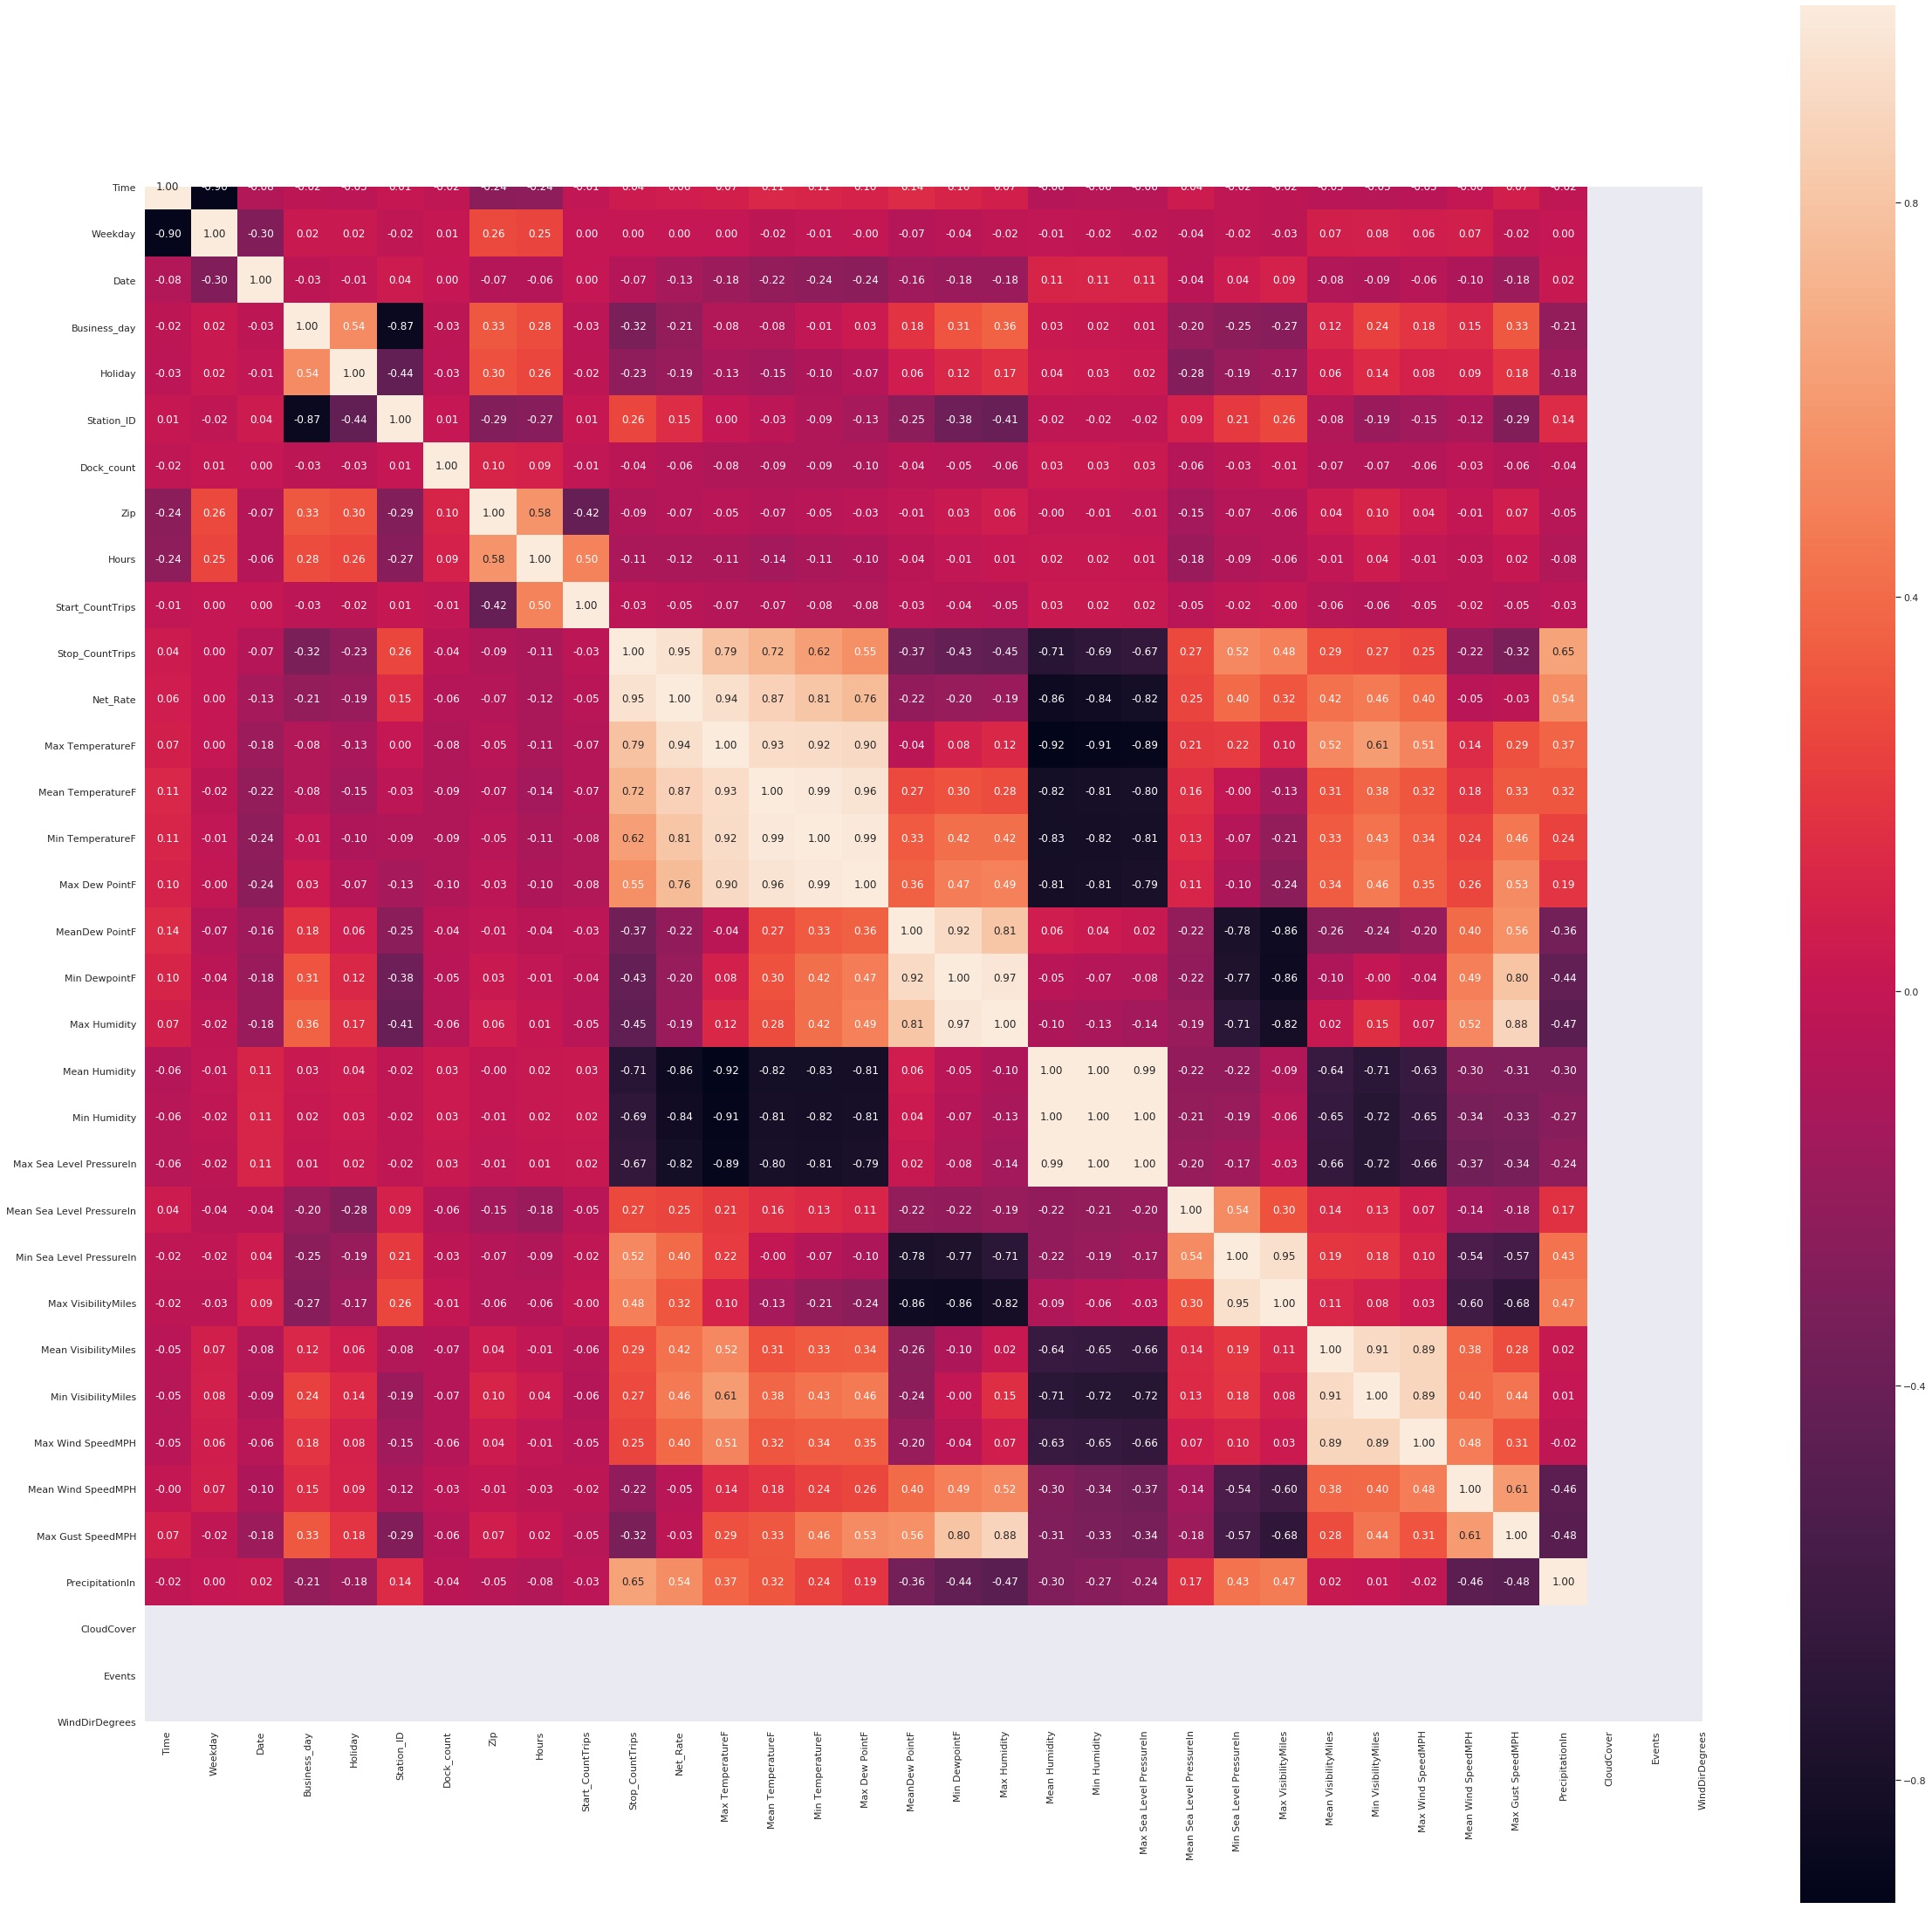

In [54]:
correlation_map = np.corrcoef(correlation)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=dataset.columns, xticklabels=dataset.columns)
plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

In this part, it is shown which features are mostly corellated with our target variable Net_Rate

In [55]:
correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(15, 'Net_Rate').index
columns

Index(['Net_Rate', 'Stop_CountTrips', 'Hours', 'Dock_count',
       'Max VisibilityMiles', 'Min Sea Level PressureIn',
       'Mean Sea Level PressureIn', 'Max Gust SpeedMPH', 'Mean Wind SpeedMPH',
       'Max Sea Level PressureIn', 'Zip', 'Max TemperatureF',
       'Mean TemperatureF', 'CloudCover', 'Weekday'],
      dtype='object')

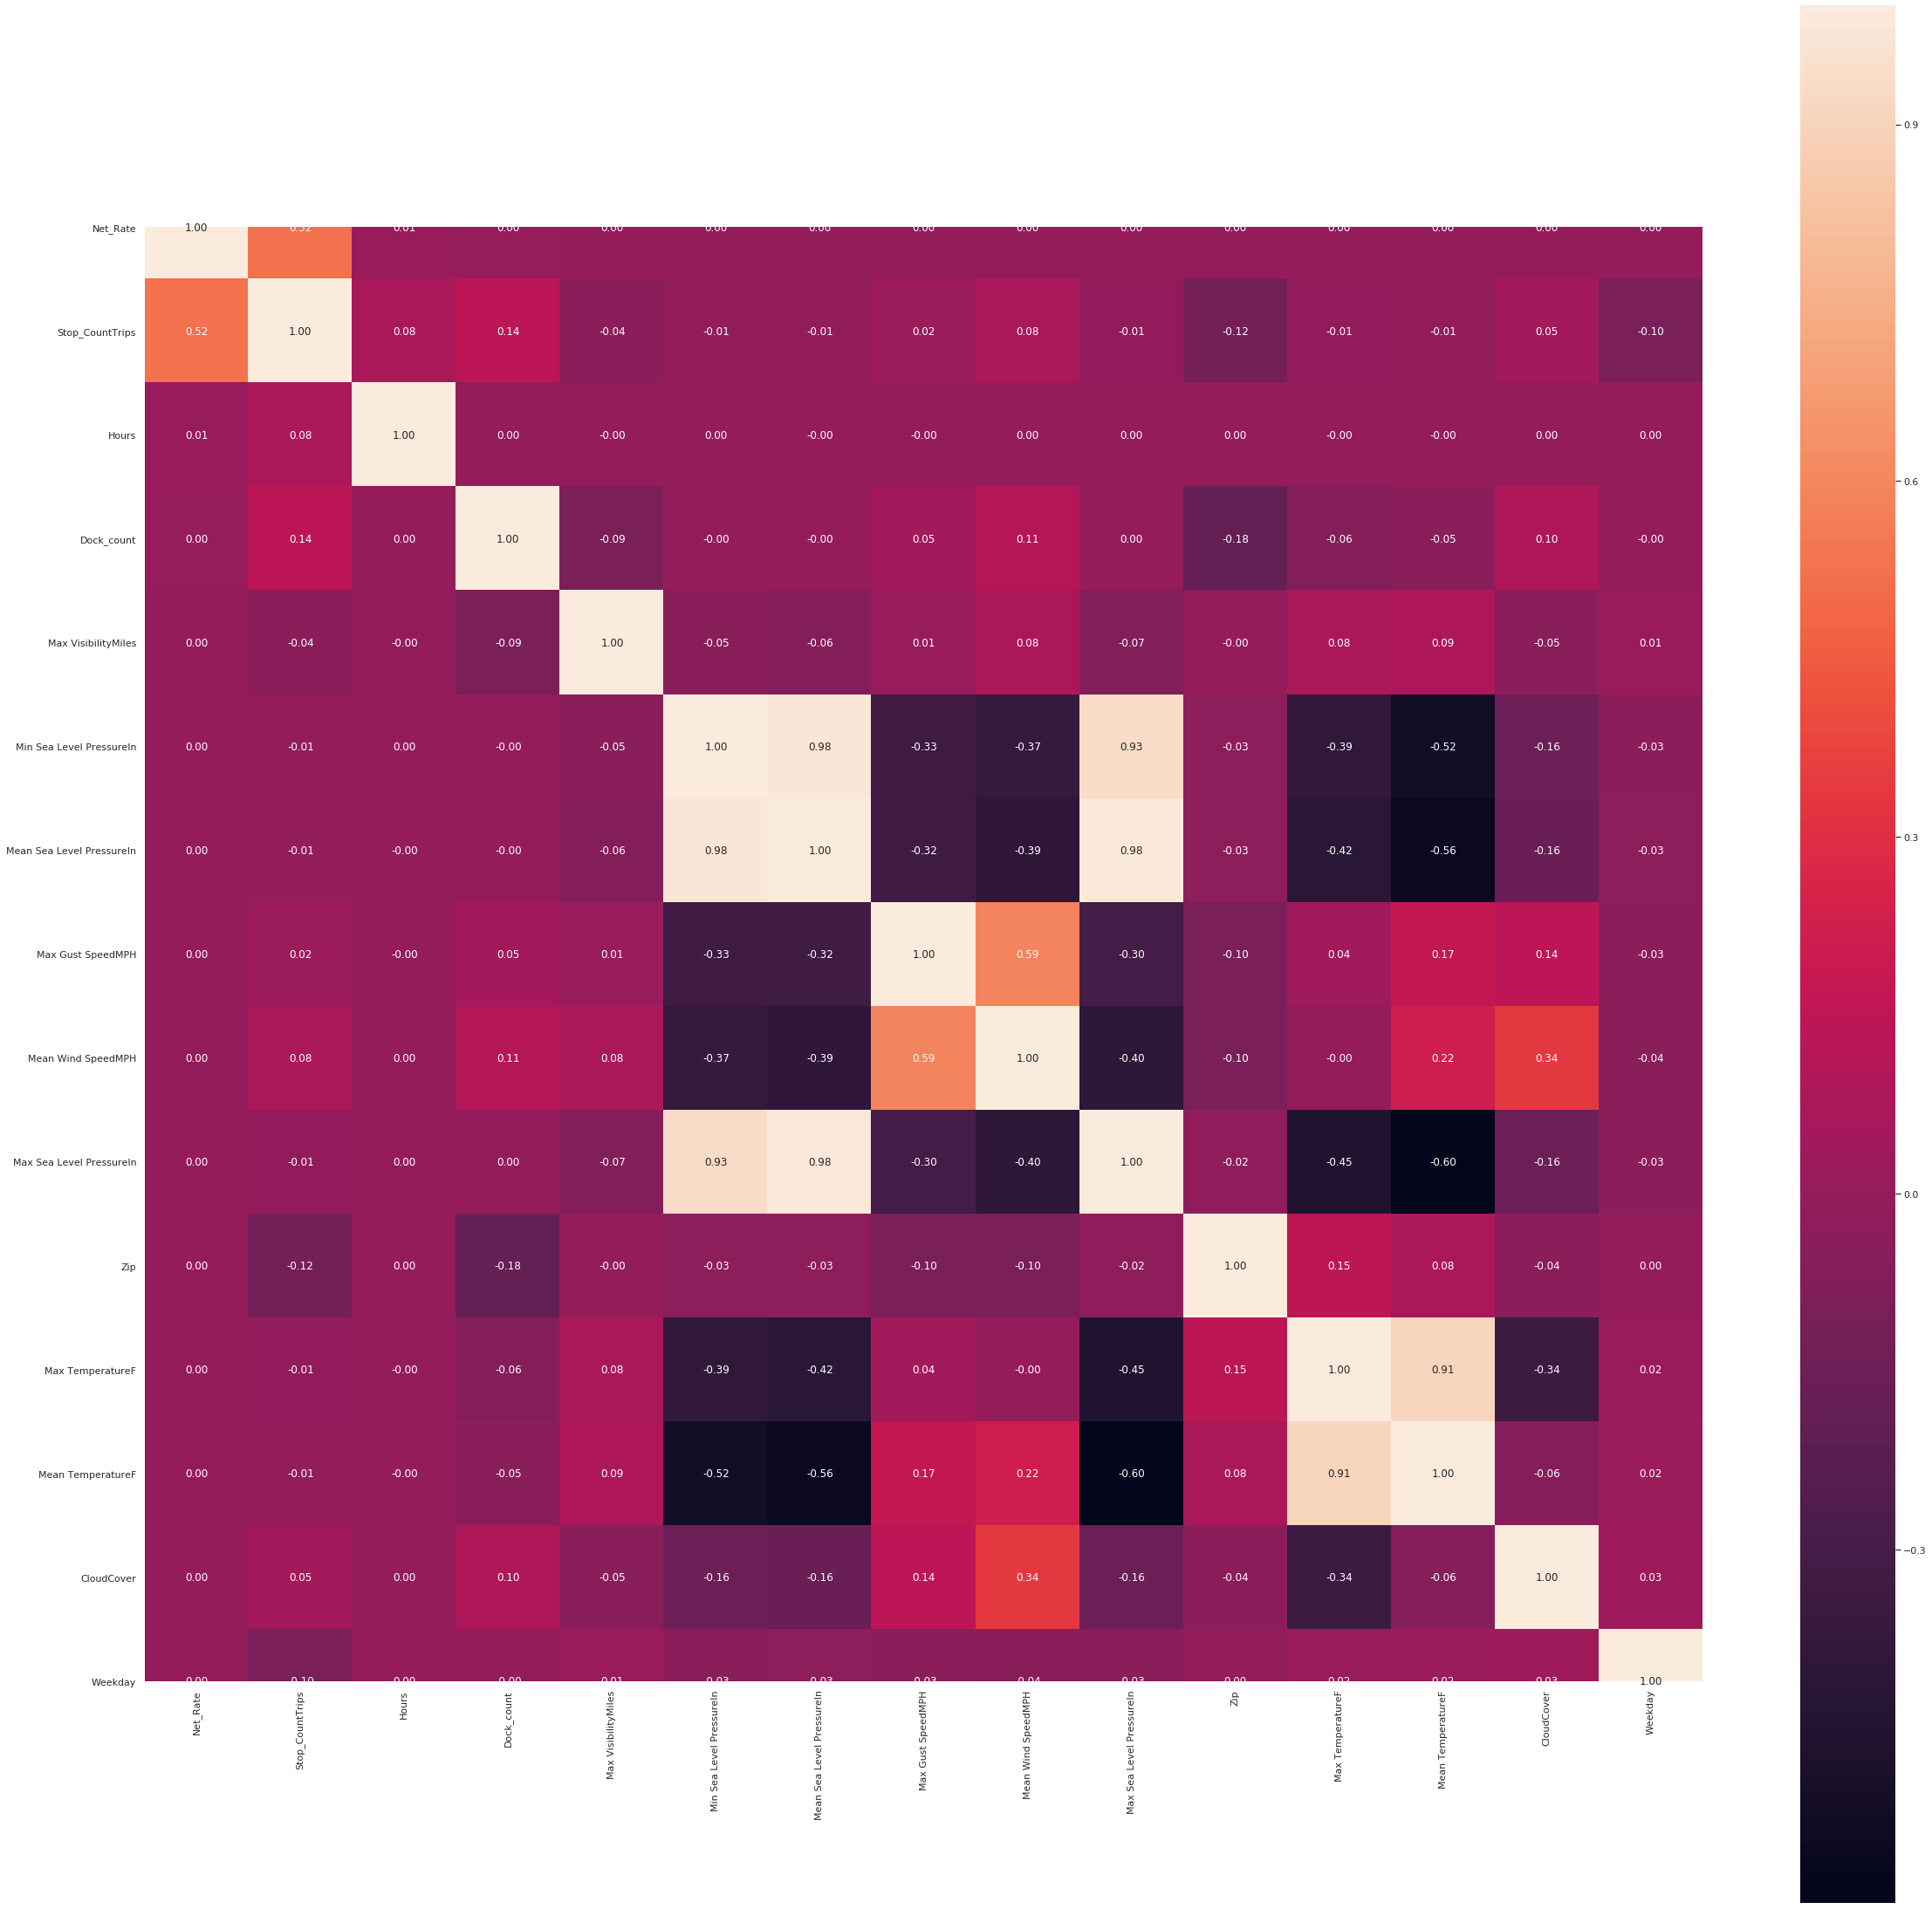

In [56]:
correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.rcParams['figure.figsize'] = [25, 25]
plt.show()

At this point, a first table with train data is obtained, that could provide the necessary predictive model. However, the table will be further analysed and also specific columns will be chosen in the modeling phase. 

# Modelling Approach

The problem is a regression problem. Thus, a gradient boosted regressor was chosen to learn and model the above data. The XGBoost model is tuned, using the Grid search approach of sklearn and also cross validation is performed to better estimate the model's performance in an unseen dataset. 

Regarding our features, first the Time column is dropped, since each specific date occurs only once in our dataset. Moreover, start and stop trip columns should be removed, because they contain all the info about the target variable(the model would easily learn to subtract the 2 columns and achieve accurate results).
Since the data are time series, it should be obvious to split the data to past for train and future for prediction. However, there is no future information linked to our estimations, since each prediction is based on the current status of each station.

In [57]:
import xgboost as xgb 
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing

In [58]:
# The specific day is not relevant since it happens only once. Keep only month from the date and hour.
dataset["Month"] = pd.to_datetime(dataset["Date"]).dt.strftime('%m')
dataset.drop(columns=['Time'],inplace=True)
##Remove the start stop count 
dataset.drop(columns=['Start_CountTrips','Stop_CountTrips'],inplace=True)

In [59]:
# Change the order of the columns in the dataframe
dataset = dataset[['Weekday','Business_day','Holiday','Station_ID', 'Dock_count','Zip','Month', 'Hours','Max TemperatureF', 
       'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       'Mean Humidity', 'Min Humidity', 'Max Sea Level PressureIn',
       'Mean Sea Level PressureIn', 'Min Sea Level PressureIn',
       'Max Wind SpeedMPH', 'Mean Wind SpeedMPH', 'Max Gust SpeedMPH',
       'PrecipitationIn', 'CloudCover','Events' , 'WindDirDegrees', 'Net_Rate']]

In [60]:
# Some of the features are necessary to be encoded. This is done using the Label encoder

lbl = preprocessing.LabelEncoder()
dataset['Month'] = lbl.fit_transform(dataset['Month'])
dataset['Hours'] = lbl.fit_transform(dataset['Hours'])
dataset['Events']=dataset['Events'].apply(str)
dataset['Events'] = lbl.fit_transform(dataset['Events'])
dataset['Zip'] = lbl.fit_transform(dataset['Zip'])

#Change type of values depending on their nature 
dataset['Station_ID']=dataset['Station_ID'].apply(int)
dataset['Dock_count']=dataset['Dock_count'].apply(int)
dataset['Net_Rate']=dataset['Net_Rate'].apply(int)


In [61]:
# Separate features and target variable

X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]

#print(y)
data_dmatrix = xgb.DMatrix(data=X, label=y)

# Random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [121]:
# Use GridSearch method to get the best parameters of the model
# Moreover, multiple experiments were done to get an insight of the model parameters
# It will take some time to complete

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

parameters= {
       "colsample_bytree":[0.6,1.0],
       "subsample":[0.6,1.0],
       "min_child_weight":[1,4],
       "learning_rate": [0.1,0.3],
       "max_depth" :[7,12],
       "reg_alpha" :[1,30],
       "n_estimators" :[50]
}

xg_reg_gs = GridSearchCV(xg_reg, parameters, n_jobs=2, cv=2, refit=True)

xg_reg_gs.fit(X_train,y_train, eval_metric='rmse',verbose=True)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_st...ambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=2,
             param_grid={'colsample_bytree': [0.6, 1.0],
                         'learning_rate': [0.1, 0.3], 'max_depth': [7, 12],
        

In [123]:
results = xg_reg_gs.cv_results_
score = xg_reg_gs.best_score_
print('score:', score)
print(xg_reg_gs.best_params_)

score: 0.5490230880964797
{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 50, 'reg_alpha': 30, 'subsample': 1.0}


I start with a single training to get an idea about the parameters and use the best combination that found using GridSearch. The GridSearch provides us with a good combination of parameters. Then, additional experimentation was made.

In [178]:
eval_set = [(X_train, y_train), (X_test, y_test)]

# The XGB regressor object with the parameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1.0, learning_rate = 0.30, subsample=1.0,
                max_depth = 12, reg_alpha=30, min_child_weight=4 ,n_estimators = 100) #15

In [179]:
# Train the regressor

xg_reg.fit(X_train,y_train, eval_metric='rmse',eval_set=eval_set,verbose=True)

[0]	validation_0-rmse:1.48216	validation_1-rmse:1.45994
[1]	validation_0-rmse:1.36307	validation_1-rmse:1.35077
[2]	validation_0-rmse:1.27211	validation_1-rmse:1.267
[3]	validation_0-rmse:1.2201	validation_1-rmse:1.22056
[4]	validation_0-rmse:1.17999	validation_1-rmse:1.18468
[5]	validation_0-rmse:1.15612	validation_1-rmse:1.16574
[6]	validation_0-rmse:1.13206	validation_1-rmse:1.14693
[7]	validation_0-rmse:1.11799	validation_1-rmse:1.13505
[8]	validation_0-rmse:1.10291	validation_1-rmse:1.12465
[9]	validation_0-rmse:1.089	validation_1-rmse:1.11682
[10]	validation_0-rmse:1.08287	validation_1-rmse:1.1137
[11]	validation_0-rmse:1.07345	validation_1-rmse:1.10631
[12]	validation_0-rmse:1.06795	validation_1-rmse:1.10228
[13]	validation_0-rmse:1.06242	validation_1-rmse:1.09908
[14]	validation_0-rmse:1.05673	validation_1-rmse:1.09484
[15]	validation_0-rmse:1.04787	validation_1-rmse:1.0888
[16]	validation_0-rmse:1.04209	validation_1-rmse:1.08594
[17]	validation_0-rmse:1.03855	validation_1-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=12, min_child_weight=4, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=30, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

In [128]:
# 3-fold Cross Validation is being performed
params = {"objective":"reg:squarederror", "colsample_bytree": 1.0, "learning_rate":0.30, "subsample":1.0,
          "min_child_weight":4,"max_depth":12, "reg_alpha":30}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

print(cv_results)

print((cv_results["test-rmse-mean"]).tail(1))

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           1.475910        0.003836        1.479549       0.015773
1           1.351627        0.006594        1.361126       0.014861
2           1.265852        0.007994        1.280736       0.010898
3           1.214202        0.004217        1.233338       0.008858
4           1.173336        0.006123        1.196828       0.011783
..               ...             ...             ...            ...
103         0.905968        0.001255        1.043520       0.002262
104         0.905327        0.001217        1.043483       0.002357
105         0.904442        0.001266        1.043343       0.002362
106         0.903755        0.001175        1.043318       0.002392
107         0.903035        0.001259        1.043225       0.002287

[108 rows x 4 columns]
107    1.043225
Name: test-rmse-mean, dtype: float64


In [133]:
# Predictions at test set
preds = xg_reg.predict(X_test)
# Predictions at train
train_preds = xg_reg.predict(X_train)

# Root mean square error at test set
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE_test: %f" % (rmse))

# Root mean square error at train set
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
print("RMSE_train: %f" % (rmse_train))

gain = xg_reg._Booster.get_score(importance_type='gain')
print(gain)

# cover = xg_reg._Booster.get_score(importance_type='cover')
# print(cover)

RMSE_test: 1.039538
RMSE_train: 0.911369
{'bikes_available': 13.420537390559128, 'Hours': 24.349498986767784, 'Dock_count': 35.527951883091454, 'Station_ID': 39.879495341058394, 'Business_day': 74.19203978539136, 'Events': 2.369128516518445, 'PrecipitationIn': 2.8087168859307163, 'Month': 14.447384585626978, 'Weekday': 11.512204469236078, 'Mean_TemperatureF': 4.314044789481135}


Above we can also see the gain each features add to the model's estimation.

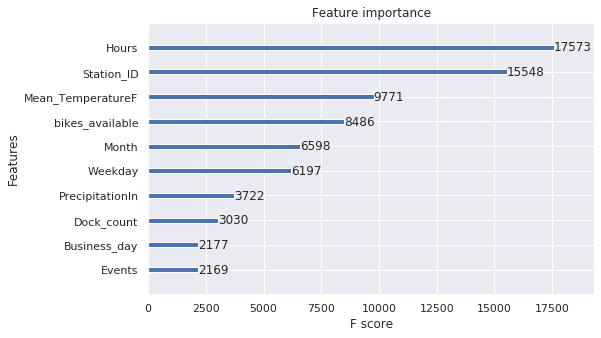

In [134]:
# Here we plot the important features of the Regressor
plot_importance(xg_reg._Booster)

plt.rcParams['figure.figsize'] = [8, 5]

plt.show()

#### Feature Engineering

By running some experiments which are skipped above, the following conclusions, about which features improve the performance, are made:
* with Dock_count
* without Zip
* with PrecipitationIN
* without WindSpeed
* without Holidays
* with Business_days
* With Temperature

We can see that it is better to remove highly corellated columns from our features. Also, a high correlated feature with the target variable, like WindDir does not mean that could provide meaningful information in predicting the net rate, and may lead to overfitting. Thus, the models will be shown to perform better after removing them.

__No improvement in the validation RMSE was shown while removing the features based on the above list.__


In [137]:
dataset2 = dataset[['Weekday','Business_day','Station_ID','Dock_count','Month', 'Hours', 
       'Mean TemperatureF', 'PrecipitationIn','Events', 'Net_Rate']]

In [138]:
dataset2

,Weekday,Business_day,Station_ID,Dock_count,Month,Hours,Mean TemperatureF,PrecipitationIn,Events,Net_Rate
0,0,0,2,27,8,0,72.0,0.0,2,0
1,0,0,2,27,8,1,72.0,0.0,2,0
2,0,0,2,27,8,2,72.0,0.0,2,0
3,0,0,2,27,8,3,72.0,0.0,2,0
4,0,0,2,27,8,4,72.0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...
665792,0,1,82,15,7,19,69.0,0.0,2,-1
665793,0,1,82,15,7,20,69.0,0.0,2,1
665794,0,1,82,15,7,21,69.0,0.0,2,2
665795,0,1,82,15,7,22,69.0,0.0,2,0


In [139]:
# Separate features and target variable

X, y = dataset2.iloc[:,:-1], dataset2.iloc[:,-1]

#print(y)
data_dmatrix = xgb.DMatrix(data=X, label=y)

# Random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [146]:
eval_set = [(X_train, y_train), (X_test, y_test)]

# The XGB regressor object with the parameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',colsample_bytree=1, colsample_bylevel=1, 
                          colsample_bynode=1, learning_rate = 0.3, subsample=1, max_depth = 12, min_child_weight=4, 
                          reg_alpha=30, n_estimators = 100) #15

In [147]:
xg_reg.fit(X_train,y_train, eval_metric='rmse',eval_set=eval_set,verbose=True)

[0]	validation_0-rmse:1.43273	validation_1-rmse:1.41124
[1]	validation_0-rmse:1.29361	validation_1-rmse:1.28126
[2]	validation_0-rmse:1.21332	validation_1-rmse:1.21038
[3]	validation_0-rmse:1.16355	validation_1-rmse:1.16685
[4]	validation_0-rmse:1.129	validation_1-rmse:1.13796
[5]	validation_0-rmse:1.10849	validation_1-rmse:1.12361
[6]	validation_0-rmse:1.09188	validation_1-rmse:1.11126
[7]	validation_0-rmse:1.08121	validation_1-rmse:1.10413
[8]	validation_0-rmse:1.07156	validation_1-rmse:1.0956
[9]	validation_0-rmse:1.06458	validation_1-rmse:1.08969
[10]	validation_0-rmse:1.06118	validation_1-rmse:1.08817
[11]	validation_0-rmse:1.0588	validation_1-rmse:1.08642
[12]	validation_0-rmse:1.05444	validation_1-rmse:1.08241
[13]	validation_0-rmse:1.04882	validation_1-rmse:1.08021
[14]	validation_0-rmse:1.04652	validation_1-rmse:1.07861
[15]	validation_0-rmse:1.04369	validation_1-rmse:1.0774
[16]	validation_0-rmse:1.0429	validation_1-rmse:1.07702
[17]	validation_0-rmse:1.04123	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=12, min_child_weight=4, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=30, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

3-fold Cross Validation is also performed using the above model and features.

In [149]:
params = {"objective":"reg:squarederror","colsample_bytree":1, "colsample_bylevel":1, 
                          "colsample_bynode":1, "learning_rate":0.3, "subsample":1, "max_depth":12, #10
                          "reg_alpha":35, "n_estimators":100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

print(cv_results)

print((cv_results["test-rmse-mean"]).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          1.438285        0.002765        1.442784       0.015968
1          1.303374        0.005520        1.312569       0.012718
2          1.216102        0.001674        1.231996       0.004024
3          1.165109        0.001787        1.185945       0.002657
4          1.131991        0.003641        1.156493       0.003203
5          1.108919        0.002817        1.136379       0.000703
6          1.091899        0.001365        1.122956       0.001298
7          1.079283        0.000759        1.113080       0.002849
8          1.069938        0.001268        1.106310       0.003550
9          1.065356        0.001431        1.103305       0.003224
10         1.060217        0.000242        1.099307       0.003601
11         1.056682        0.001451        1.097250       0.003360
12         1.050912        0.002446        1.093144       0.002196
13         1.048210        0.001630        1.091978       0.00

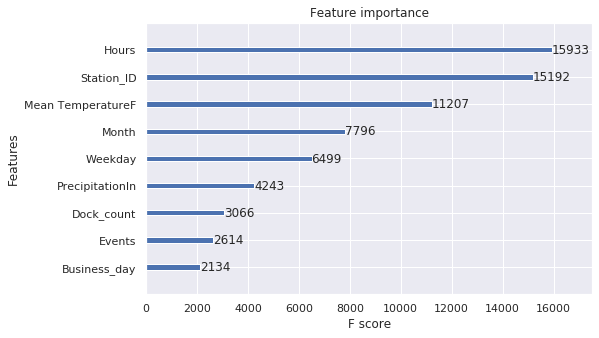

In [150]:
# Here we plot the important features of the Regressor
plot_importance(xg_reg._Booster)

plt.rcParams['figure.figsize'] = [8, 5]

plt.show()

It can be seen that with the removal of the data, the performance of the model didn't improve, and it even got worse. Moreover, it was much easier to __overfit__.

#### Improvement of the dataset using external data

I decided to extent the original dataset by adding a new feature. In Kaggle another cvs file containing status data was found. Here I will try to extract information and see if by using that our model can be improved. I follow the feature analysis made above, so keep only the features that seem relevant, and the add this new feature. The data source can be found as status.csv here: https://www.kaggle.com/benhamner/sf-bay-area-bike-share

The status data are already cleaned to include only information relevant for our date range. This step is not shown here since the file was really large. This step is included in the source code.
After I clean the data, we can see that the file contains the availability of bikes and docks at each station every one minute. 
The plan for this dataframe is to extract and add in my dataset two columns containing the available bikes and free dock stations at the beginning of every hour. Thus I have to groupby the info contained in the statusDf on hour,time and stationID. Then I will keep only the last value and use it as info for the next hour, meaning that this value is the number of available bikes at the beginning of the next hour.

In [151]:
avail_bikes = pd.read_csv("../code/rel_data.csv",parse_dates=[3],dayfirst=True,index_col=0)

In [152]:
avail_bikes

,station_id,bikes_available,docks_available,time
0,2,15,12,2014-09-01 00:59:03
1,3,9,6,2014-09-01 00:59:03
2,4,5,6,2014-09-01 00:59:03
3,5,8,11,2014-09-01 00:59:03
4,6,8,7,2014-09-01 00:59:03
...,...,...,...,...
611630,77,13,14,2015-08-31 23:59:02
611631,80,7,8,2015-08-31 23:59:02
611632,82,5,10,2015-08-31 23:59:02
611633,83,5,10,2015-08-31 23:59:02


In [153]:
avail_bikes["Date"] = pd.to_datetime(avail_bikes["time"]).dt.date
avail_bikes["Hours"] = pd.to_datetime(avail_bikes["time"]).dt.hour
#Rename station_id col to fit the other col name
avail_bikes.columns= ["Station_ID","bikes_available","docks_available","time","Date","Hours"]
avail_bikes["Date"] = pd.to_datetime(avail_bikes["Date"])

In [154]:
avail_bikes['docks_available']=avail_bikes['docks_available'].apply(int)
avail_bikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611635 entries, 0 to 611634
Data columns (total 6 columns):
Station_ID         611635 non-null int64
bikes_available    611635 non-null int64
docks_available    611635 non-null int64
time               611635 non-null object
Date               611635 non-null datetime64[ns]
Hours              611635 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 32.7+ MB


In [155]:
# Here I merge the above table with the feature table merging the two dataframes on date, hour and stationID
dataset_avail = pd.merge(merged_weather,avail_bikes,on=["Date","Hours","Station_ID"],how="outer")

In [156]:
dataset_avail.drop(columns=['Date','time'],inplace=True)

In [157]:
dataset_avail

,Weekday,Business_day,Holiday,Station_ID,Dock_count,Zip,Hours,Net_Rate,Max TemperatureF,Mean TemperatureF,...,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Month,bikes_available,docks_available
0,0,0,1,2.0,27.0,95113.0,0,0.0,86.0,72.0,...,17.0,5.0,22.0,0.0,0.0,Normal,296.0,09,15.0,12.0
1,0,0,1,2.0,27.0,95113.0,1,0.0,86.0,72.0,...,17.0,5.0,22.0,0.0,0.0,Normal,296.0,09,15.0,12.0
2,0,0,1,2.0,27.0,95113.0,2,0.0,86.0,72.0,...,17.0,5.0,22.0,0.0,0.0,Normal,296.0,09,14.0,13.0
3,0,0,1,2.0,27.0,95113.0,3,0.0,86.0,72.0,...,17.0,5.0,22.0,0.0,0.0,Normal,296.0,09,15.0,12.0
4,0,0,1,2.0,27.0,95113.0,4,0.0,86.0,72.0,...,17.0,5.0,22.0,0.0,0.0,Normal,296.0,09,15.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665755,0,1,0,82.0,15.0,94107.0,19,-1.0,78.0,69.0,...,18.0,9.0,21.0,0.0,1.0,Normal,246.0,08,0.0,15.0
665756,0,1,0,82.0,15.0,94107.0,20,1.0,78.0,69.0,...,18.0,9.0,21.0,0.0,1.0,Normal,246.0,08,4.0,11.0
665757,0,1,0,82.0,15.0,94107.0,21,2.0,78.0,69.0,...,18.0,9.0,21.0,0.0,1.0,Normal,246.0,08,6.0,9.0
665758,0,1,0,82.0,15.0,94107.0,22,0.0,78.0,69.0,...,18.0,9.0,21.0,0.0,1.0,Normal,246.0,08,6.0,9.0


In [158]:
# We can see that the size of the status data obtained has less rows(611635 instead of 665760) than the one we have. That is
# we have some missing values as we see below
dataset_avail.isnull().sum()

Weekday                          0
Business_day                     0
Holiday                          0
Station_ID                       0
Dock_count                       0
Zip                              0
Hours                            0
Net_Rate                         0
Max TemperatureF                 0
Mean TemperatureF                0
Min TemperatureF                 0
Max Dew PointF                   0
MeanDew PointF                   0
Min DewpointF                    0
Max Humidity                     0
Mean Humidity                    0
Min Humidity                     0
Max Sea Level PressureIn         0
Mean Sea Level PressureIn        0
Min Sea Level PressureIn         0
Max VisibilityMiles              0
Mean VisibilityMiles             0
Min VisibilityMiles              0
Max Wind SpeedMPH                0
Mean Wind SpeedMPH               0
Max Gust SpeedMPH                0
PrecipitationIn                  0
CloudCover                       0
Events              

We repeat now the same steps as before in the modeling to train our model.

In [170]:
# Change the order of the columns in the dataframe
dataset_avail2 = dataset_avail[['Weekday','Business_day','Station_ID','Dock_count','Month', 'Hours', 
       'Mean TemperatureF','PrecipitationIn','Events' ,'bikes_available', 'Net_Rate']]


In [171]:
dataset_avail2

,Weekday,Business_day,Station_ID,Dock_count,Month,Hours,Mean TemperatureF,PrecipitationIn,Events,bikes_available,Net_Rate
0,0,0,2.0,27.0,09,0,72.0,0.0,Normal,15.0,0.0
1,0,0,2.0,27.0,09,1,72.0,0.0,Normal,15.0,0.0
2,0,0,2.0,27.0,09,2,72.0,0.0,Normal,14.0,0.0
3,0,0,2.0,27.0,09,3,72.0,0.0,Normal,15.0,0.0
4,0,0,2.0,27.0,09,4,72.0,0.0,Normal,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
665755,0,1,82.0,15.0,08,19,69.0,0.0,Normal,0.0,-1.0
665756,0,1,82.0,15.0,08,20,69.0,0.0,Normal,4.0,1.0
665757,0,1,82.0,15.0,08,21,69.0,0.0,Normal,6.0,2.0
665758,0,1,82.0,15.0,08,22,69.0,0.0,Normal,6.0,0.0


In [172]:
# Some of the features are necessary to be encoded. This is done using the Label encoder

lbl = preprocessing.LabelEncoder()
dataset_avail2['Month'] = lbl.fit_transform(dataset_avail2['Month'])
dataset_avail2['Hours'] = lbl.fit_transform(dataset_avail2['Hours'])
dataset_avail2['Events']=dataset_avail2['Events'].apply(str)
dataset_avail2['Events'] = lbl.fit_transform(dataset_avail2['Events'])

#Change type of values depending on their nature 
dataset_avail2['Station_ID']=dataset_avail2['Station_ID'].apply(int)
dataset_avail2['Dock_count']=dataset_avail2['Dock_count'].apply(int)
#dataset_avail['docks_available']=dataset_avail['docks_available'].apply(int)
dataset_avail2['Net_Rate']=dataset_avail2['Net_Rate'].apply(int)


In [173]:
# Separate features and target variable

X, y = dataset_avail2.iloc[:,:-1], dataset_avail2.iloc[:,-1]

#print(y)
data_dmatrix = xgb.DMatrix(data=X, label=y)

# Random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

I use exactly the same parameters as I used for training the previous model above. These parameters were shown to give the best results, thus it can safely stated that the added feature of available_bikes was important in improving the model's perfomance, by comparing the 2 models RMSE.

In [174]:
eval_set = [(X_train, y_train), (X_test, y_test)]

# The XGB regressor object with the parameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',colsample_bytree=1, colsample_bylevel=1, 
                          colsample_bynode=1, learning_rate = 0.11, subsample=1, max_depth = 15,
                          reg_alpha=50, reg_lambda=100, n_estimators = 350) #15

In [175]:
xg_reg.fit(X_train,y_train, eval_metric='rmse',eval_set=eval_set,verbose=True)

[0]	validation_0-rmse:1.61633	validation_1-rmse:1.58648
[1]	validation_0-rmse:1.56421	validation_1-rmse:1.53724
[2]	validation_0-rmse:1.52226	validation_1-rmse:1.49457
[3]	validation_0-rmse:1.48228	validation_1-rmse:1.45406
[4]	validation_0-rmse:1.44503	validation_1-rmse:1.41945
[5]	validation_0-rmse:1.41268	validation_1-rmse:1.38838
[6]	validation_0-rmse:1.38339	validation_1-rmse:1.35963
[7]	validation_0-rmse:1.35869	validation_1-rmse:1.33569
[8]	validation_0-rmse:1.33387	validation_1-rmse:1.31394
[9]	validation_0-rmse:1.31081	validation_1-rmse:1.29319
[10]	validation_0-rmse:1.29121	validation_1-rmse:1.27478
[11]	validation_0-rmse:1.27249	validation_1-rmse:1.25777
[12]	validation_0-rmse:1.25695	validation_1-rmse:1.2437
[13]	validation_0-rmse:1.24047	validation_1-rmse:1.22885
[14]	validation_0-rmse:1.22405	validation_1-rmse:1.2142
[15]	validation_0-rmse:1.20995	validation_1-rmse:1.20174
[16]	validation_0-rmse:1.19844	validation_1-rmse:1.19185
[17]	validation_0-rmse:1.18648	validation_1

[143]	validation_0-rmse:0.96586	validation_1-rmse:1.03337
[144]	validation_0-rmse:0.96549	validation_1-rmse:1.03332
[145]	validation_0-rmse:0.965138	validation_1-rmse:1.03326
[146]	validation_0-rmse:0.96467	validation_1-rmse:1.0332
[147]	validation_0-rmse:0.964358	validation_1-rmse:1.03317
[148]	validation_0-rmse:0.96407	validation_1-rmse:1.03316
[149]	validation_0-rmse:0.963756	validation_1-rmse:1.03315
[150]	validation_0-rmse:0.963303	validation_1-rmse:1.03299
[151]	validation_0-rmse:0.962919	validation_1-rmse:1.03296
[152]	validation_0-rmse:0.962631	validation_1-rmse:1.03294
[153]	validation_0-rmse:0.962174	validation_1-rmse:1.03283
[154]	validation_0-rmse:0.961657	validation_1-rmse:1.03263
[155]	validation_0-rmse:0.961033	validation_1-rmse:1.03222
[156]	validation_0-rmse:0.960668	validation_1-rmse:1.03211
[157]	validation_0-rmse:0.960357	validation_1-rmse:1.03205
[158]	validation_0-rmse:0.959935	validation_1-rmse:1.03196
[159]	validation_0-rmse:0.959503	validation_1-rmse:1.03185
[1

[283]	validation_0-rmse:0.931679	validation_1-rmse:1.02769
[284]	validation_0-rmse:0.931539	validation_1-rmse:1.02766
[285]	validation_0-rmse:0.931251	validation_1-rmse:1.02748
[286]	validation_0-rmse:0.931069	validation_1-rmse:1.02742
[287]	validation_0-rmse:0.930925	validation_1-rmse:1.02745
[288]	validation_0-rmse:0.930738	validation_1-rmse:1.02741
[289]	validation_0-rmse:0.930569	validation_1-rmse:1.02736
[290]	validation_0-rmse:0.930394	validation_1-rmse:1.02738
[291]	validation_0-rmse:0.930228	validation_1-rmse:1.02741
[292]	validation_0-rmse:0.930092	validation_1-rmse:1.02739
[293]	validation_0-rmse:0.929989	validation_1-rmse:1.02742
[294]	validation_0-rmse:0.929821	validation_1-rmse:1.02738
[295]	validation_0-rmse:0.929653	validation_1-rmse:1.02738
[296]	validation_0-rmse:0.929512	validation_1-rmse:1.02737
[297]	validation_0-rmse:0.929275	validation_1-rmse:1.02737
[298]	validation_0-rmse:0.929036	validation_1-rmse:1.02731
[299]	validation_0-rmse:0.928799	validation_1-rmse:1.027

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.11, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=350,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=50, reg_lambda=100, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [103]:
# See some predictions of the model

preds = xg_reg.predict(X_test)
preds_df = pd.DataFrame(preds, y_test)
preds_df.head(20)
#preds_df.to_csv("preds_last.csv")

,0
Net_Rate,
5,1.508265
0,0.006555
0,0.365989
0,0.004635
-1,-0.163201
0,0.014411
2,-1.097256
0,-0.022960
-1,-0.800496


In [104]:
# Cross Validation
params = {"objective":"reg:squarederror","colsample_bytree":1,"colsample_bynode":1, 
          "learning_rate":0.11, "subsample":1, "max_depth":15,"reg_alpha":50,"reg_lambda":100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=500, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

print(cv_results)

print((cv_results["test-rmse-mean"]).tail(1))

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           1.612889        0.004752        1.612300       0.018289
1           1.560940        0.004566        1.563699       0.018147
2           1.517508        0.003433        1.520262       0.018817
3           1.478990        0.003716        1.481423       0.018408
4           1.441445        0.003707        1.447231       0.018229
..               ...             ...             ...            ...
353         0.921483        0.000789        1.033871       0.004336
354         0.921350        0.000818        1.033854       0.004320
355         0.921240        0.000807        1.033850       0.004329
356         0.921136        0.000803        1.033840       0.004313
357         0.920977        0.000804        1.033813       0.004317

[358 rows x 4 columns]
357    1.033813
Name: test-rmse-mean, dtype: float64


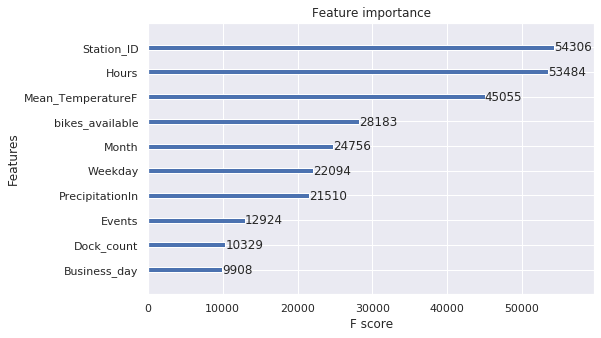

In [105]:
# Here we plot the important features of the Regressor
plot_importance(xg_reg._Booster)

plt.rcParams['figure.figsize'] = [8, 5]
plt.show()

# The tree is to large to be visualized

Here I try another model for predicting the net rate change. So that we can compare the two models together. I will compare the XGboost regressor with the Gradient Boosting regressor.

In [188]:
gbr = GradientBoostingRegressor(learning_rate = 0.20,
                                n_estimators = 50,
                                max_depth = 10,
                                min_samples_leaf = 1,
                                criterion="mse",
                                verbose=True,
                                random_state = 2)

In [185]:
# I fill the nan values since gradient boosting cannot work with nan values as XGB.
X.fillna(X.mean(), inplace=True)
X.isnull().sum()

Weekday              0
Business_day         0
Station_ID           0
Dock_count           0
Month                0
Hours                0
Mean TemperatureF    0
PrecipitationIn      0
Events               0
bikes_available      0
dtype: int64

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

gbr.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           2.2083           12.15m
         2           1.9702           10.38m
         3           1.8097            9.55m
         4           1.6608            9.22m
         5           1.5355            8.95m
         6           1.4874            8.65m
         7           1.4529            8.27m
         8           1.4240            8.04m
         9           1.3867            7.80m
        10           1.3179            7.56m
        20           1.0835            5.22m
        30           0.9915            3.31m
        40           0.9204            1.65m
        50           0.8676            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.3, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='auto', random_state=2,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=True, warm_start=False)

In [187]:
# Predictions at test set
preds_gbr = gbr.predict(X_test)

# Root mean square error at test set
rmse_gbr = np.sqrt(mean_squared_error(y_test, preds_gbr))
print("RMSE_test: %f" % (rmse_gbr))

RMSE_test: 1.061003


In [196]:
# Cross validation is being performed 

scores = cross_val_score(gbr, X, y, cv=5, n_jobs=2, scoring = 'neg_mean_squared_error')

In [197]:
# See the scores
rmse = np.sqrt(-scores)
print(rmse)
mean_rmse = np.mean(rmse)
mean_rmse

[0.67129841 0.59370638 1.39719009 1.58182449 1.73171191]


1.1951462571672358

# Performance Analysis

In this section we will discuss the different results, that were achieved at the modelling section. A small explanation will be given on each one of the models and different versions of the train dataset.


| DatasetVersion | Model | CrossVal RMSE |
| --- | --- | --- | 
| WithAllWeatherData | XGBoost | 1.043 |
| RelevantFeatures | XGBoost | 1.078 |
| WithAvailBikes | XGBoost | 1.033 |
| WithAvailBikes | GradientBoosting | 1.195

It can be seen, that with a simple feature selection, based on correlation and importance, and the addition of an extra feature we were able to slightly increase the model's performance. It is interesting that all the initial features plus the available bikes did not improve the performance. For that reason, it is not being included in the above table. The extra feature helped more, when most of the weather data were removed. Moreover, the extreme gradient boosting model shows better performance than the gradient boosting model. However, the gradient boosting model parameters were not experimented in great extent, and it is possible that with further tuning, I could be able to increase the performance to similar levels with the XGboost. 

# Conclusions

In this report, I analysed the San Francisco Bike share data, and made a first attempt to generate a model that can predict the hourly change on each station. The data provided were explored and analysed. Correlations and statistics of the features were shown and taken into account in the feature selection process. Finally, the dataset was generated in order to train successfully a model. For modelling, the option of extreme gradient boosting was chosen, since it is shown to produce good results in tabular data. Moreover, it is generally fast and good in avoiding overfitting. Grid search was used to get an insight of the parameters and tune them. Furthermore, the performance was shown and estimated by doing a 3-fold cross validation on different models and different combinations of the features. An external data source was also added, introducing a useful feature for the model to better predict the net change and reduce the RMSE.

__Some remarks:__

* It was found, that not all the weather information were important to get the model with the best performance. This may be because the weather information are correlated together, but also not all the data are relevant to the net change.
* It is quite easy for the model to overfit. That is why, the small learning rates lead to a better performance. 
* XGBoost performed better than Gradient Boosting model, and moreover it was much faster to train.
* High regularization(L1, L2) had to be introduced to avoid the model from overfitting.
* An external data source containing info about the available bikes was a meaningful feature for our model and helped improve the performance.

# Potential Improvements


In this section, potential improvements are discussed:
1. To begin with, an initial improvement I would suggest, is to try to obtain *hourly weather data*. Since now we have data information only for a specific date. This information could provide us with more information on how the use of bikes changes throughout the day and how this is influenced by the weather.
2. A second idea would be to increase the date range in total, i.e include more years of data. In this case, only the data of one year is used.
3. Another idea would be to change the model approach. An alternative would be to use a time series network. For example, a Recurrent neural network or LSTM, to handle our data as a time series and forecast future changes in the stations. However, the future changes are not always dependant on the past data.
4. Last but not least, I could try to model the stations as a graph neural network. It can be seen that the stations are interconnected, ie. a lot of times bikes that start from one station may end the ride to another. This could be potentially model using a GNN.